## Import Modules

In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, f1_score
from sklearn.feature_selection import RFE

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
# import xgboost as xgb

In [3]:
pd.set_option('display.max_columns', None)

## Import Data

In [4]:
raw_data = pd.read_csv(r"E:\Legacy Files\Documents\Py-Self-Learn\credit_card_default_prediction\data\UCI_Credit_Card.csv")

In [5]:
raw_data.head()

ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1    20000.0    2          2         1   24      2      2     -1     -1   
1   2   120000.0    2          2         2   26     -1      2      0      0   
2   3    90000.0    2          2         2   34      0      0      0      0   
3   4    50000.0    2          2         1   37      0      0      0      0   
4   5    50000.0    1          2         1   57     -1      0     -1      0   

   PAY_5  PAY_6  BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  BILL_AMT5  \
0     -2     -2     3913.0     3102.0      689.0        0.0        0.0   
1      0      2     2682.0     1725.0     2682.0     3272.0     3455.0   
2      0      0    29239.0    14027.0    13559.0    14331.0    14948.0   
3      0      0    46990.0    48233.0    49291.0    28314.0    28959.0   
4      0      0     8617.0     5670.0    35835.0    20940.0    19146.0   

   BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  \
0        0.0       0.0     689.0       0.0       0.0       0.0       0.0   
1     3261.0       0.0    1000.0    1000.0    1000.0       0.0    2000.0   
2    15549.0    1518.0    1500.0    1000.0    1000.0    1000.0    5000.0   
3    29547.0    2000.0    2019.0    1200.0    1100.0    1069.0    1000.0   
4    19131.0    2000.0   36681.0   10000.0    9000.0     689.0     679.0   

   default.payment.next.month  
0                           1  
1                           1  
2                           0  
3                           0  
4                           0

## EDA

In [6]:
# Check for unique value count
raw_data.nunique()

ID                            30000
LIMIT_BAL                        81
SEX                               2
EDUCATION                         7
MARRIAGE                          4
AGE                              56
PAY_0                            11
PAY_2                            11
PAY_3                            11
PAY_4                            11
PAY_5                            10
PAY_6                            10
BILL_AMT1                     22723
BILL_AMT2                     22346
BILL_AMT3                     22026
BILL_AMT4                     21548
BILL_AMT5                     21010
BILL_AMT6                     20604
PAY_AMT1                       7943
PAY_AMT2                       7899
PAY_AMT3                       7518
PAY_AMT4                       6937
PAY_AMT5                       6897
PAY_AMT6                       6939
default.payment.next.month        2
dtype: int64

In [7]:
# Check for missing values
raw_data.isnull().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64

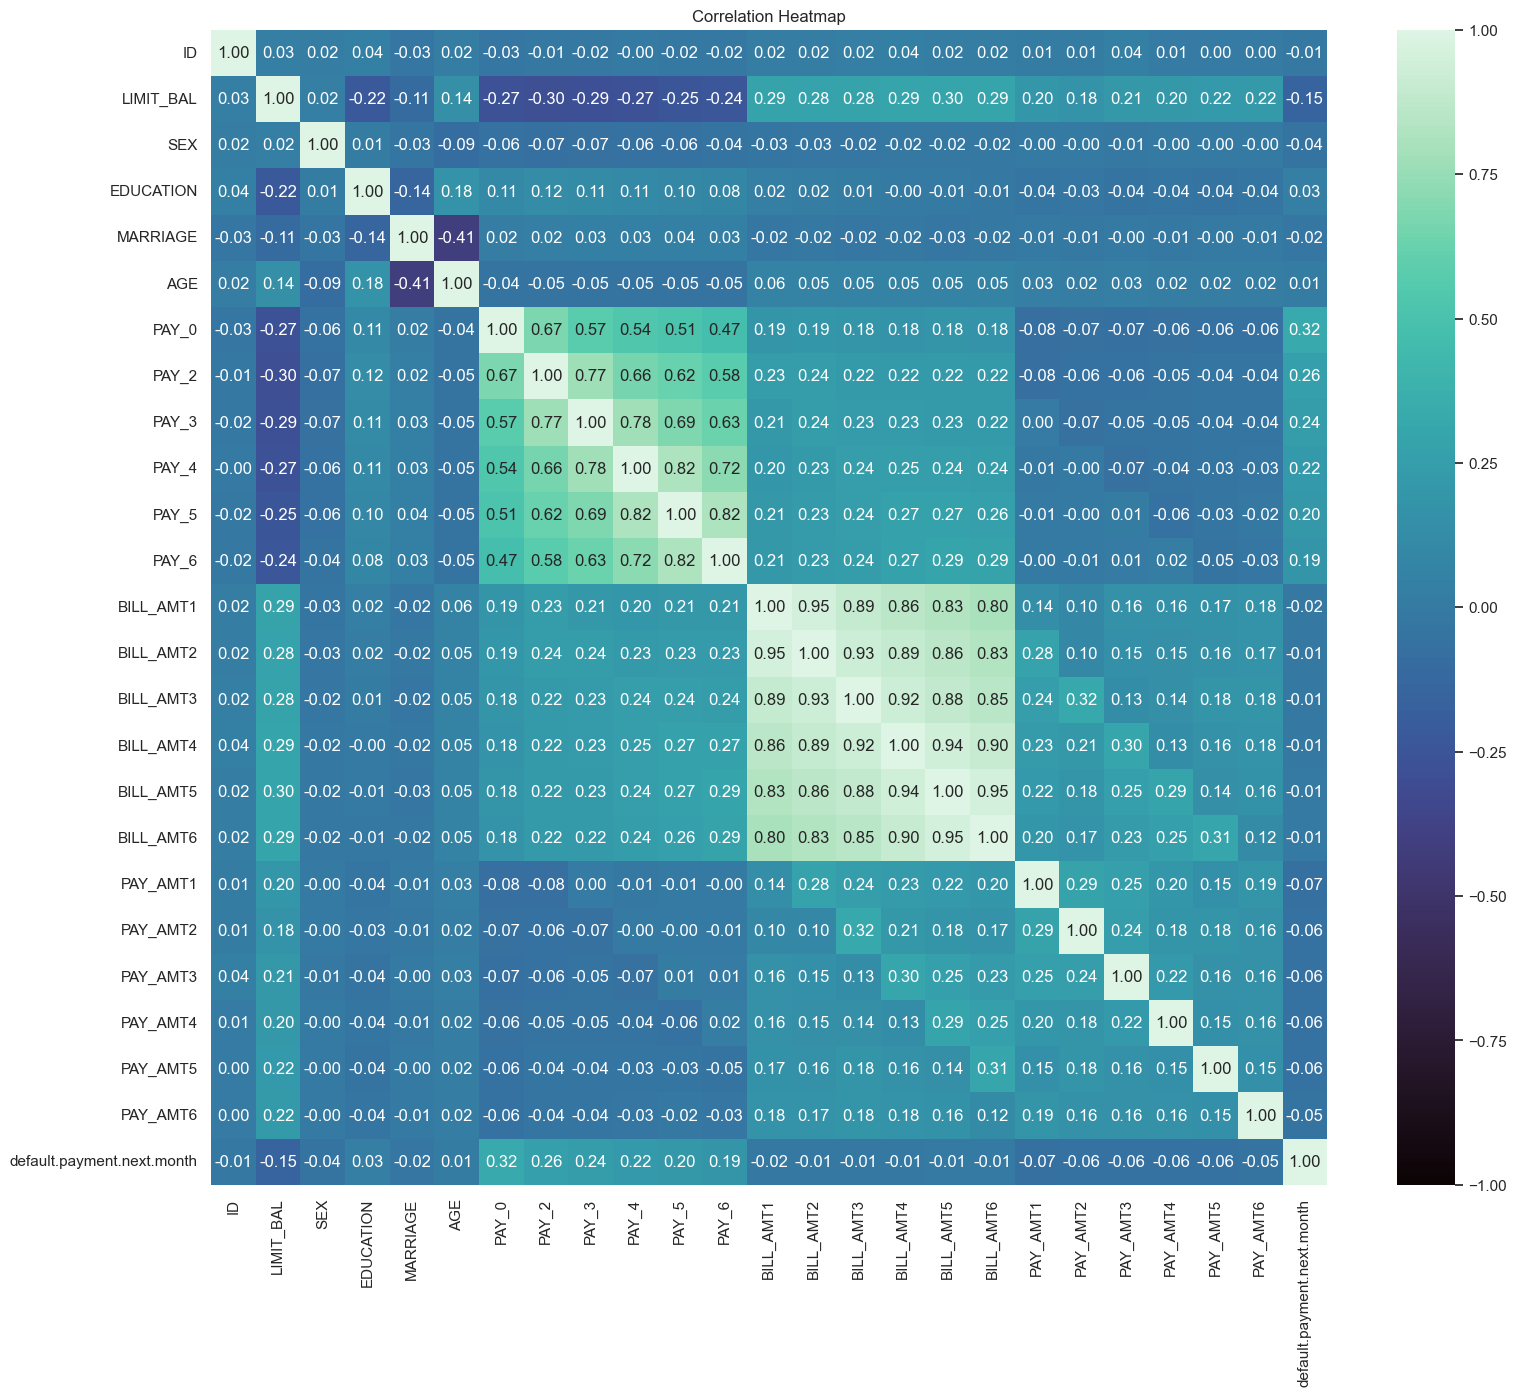

In [8]:
# Check correlation heatmap
corr = raw_data.corr()

plt.figure(figsize=(18, 15))
sns.heatmap(corr, annot=True, vmin = -1.0, cmap = 'mako', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

Notes:

Bill amounts are highly correlated, we should probably keep just one or use the mean bill amt


In [9]:
data = raw_data.copy()
data = data.drop('ID', axis=1)

In [10]:
# Get categorical and numerical features
categorical_features = [feature for feature in data.columns if data[feature].nunique() < 20 and feature != 'default.payment.next.month']
continuous_features = [feature for feature in data.columns if feature not in categorical_features and feature != 'default.payment.next.month']

In [11]:
len(continuous_features)

14

In [19]:
str(data['BILL_AMT1'].dtype)

'float64'

Text(0.5, 1.0, 'Histogram Plot')

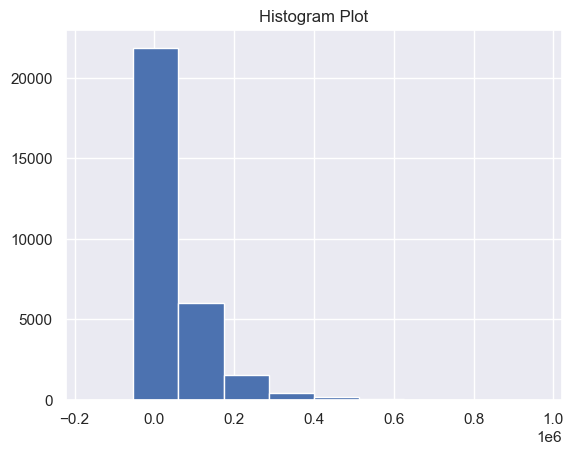

In [113]:
# Statistical Visualizaions
plt.figure()
plt.hist(data['BILL_AMT1'])
plt.title('Histogram Plot')



## Preprocessing & Feature Engineering

In [99]:
data = raw_data.copy()
data = data.drop('ID', axis=1)

In [100]:
# Merge bill amounts to an average

data['avg_bill'] = (data['BILL_AMT1'] + data['BILL_AMT2'] + data['BILL_AMT3'] + data['BILL_AMT4'] + data['BILL_AMT5'] + data['BILL_AMT6'])/6

# Use log of limit bal
data['LIMIT_BAL'] = np.log(data['LIMIT_BAL'])

data = data.drop(['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6'], axis=1)

new_cols_arrangement = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'avg_bill', 'PAY_0', 'PAY_2',
                        'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
                        'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default.payment.next.month'
                        ]
data = data[new_cols_arrangement]

In [101]:
data

LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE       avg_bill  PAY_0  PAY_2  \
0       9.903488    2          2         1   24    1284.000000      2      2   
1      11.695247    2          2         2   26    2846.166667     -1      2   
2      11.407565    2          2         2   34   16942.166667      0      0   
3      10.819778    2          2         1   37   38555.666667      0      0   
4      10.819778    1          2         1   57   18223.166667     -1      0   
...          ...  ...        ...       ...  ...            ...    ...    ...   
29995  12.301383    1          3         1   39  120891.500000      0      0   
29996  11.918391    1          3         2   43    3530.333333     -1     -1   
29997  10.308953    1          2         2   37   11749.333333      4      3   
29998  11.289782    1          3         1   41   44435.166667      1     -1   
29999  10.819778    1          2         1   46   38479.000000      0      0   

       PAY_3  PAY_4  PAY_5  PAY_6  PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  \
0         -1     -1     -2     -2       0.0     689.0       0.0       0.0   
1          0      0      0      2       0.0    1000.0    1000.0    1000.0   
2          0      0      0      0    1518.0    1500.0    1000.0    1000.0   
3          0      0      0      0    2000.0    2019.0    1200.0    1100.0   
4         -1      0      0      0    2000.0   36681.0   10000.0    9000.0   
...      ...    ...    ...    ...       ...       ...       ...       ...   
29995      0      0      0      0    8500.0   20000.0    5003.0    3047.0   
29996     -1     -1      0      0    1837.0    3526.0    8998.0     129.0   
29997      2     -1      0      0       0.0       0.0   22000.0    4200.0   
29998      0      0      0     -1   85900.0    3409.0    1178.0    1926.0   
29999      0      0      0      0    2078.0    1800.0    1430.0    1000.0   

       PAY_AMT5  PAY_AMT6  default.payment.next.month  
0           0.0       0.0                           1  
1           0.0    2000.0                           1  
2        1000.0    5000.0                           0  
3        1069.0    1000.0                           0  
4         689.0     679.0                           0  
...         ...       ...                         ...  
29995    5000.0    1000.0                           0  
29996       0.0       0.0                           0  
29997    2000.0    3100.0                           1  
29998   52964.0    1804.0                           1  
29999    1000.0    1000.0                           1  

[30000 rows x 19 columns]

In [102]:
data['avg_bill']

0          1284.000000
1          2846.166667
2         16942.166667
3         38555.666667
4         18223.166667
             ...      
29995    120891.500000
29996      3530.333333
29997     11749.333333
29998     44435.166667
29999     38479.000000
Name: avg_bill, Length: 30000, dtype: float64

In [45]:
# Get categorical and numerical features
categorical_features = [feature for feature in data.columns if data[feature].nunique() < 20 and feature != 'default.payment.next.month']
continuous_features = [feature for feature in data.columns if feature not in categorical_features and feature != 'default.payment.next.month']

Encode categorical features

In [46]:
data_temp = data.copy()
data_to_encode = data_temp[categorical_features]

# Initialize and fit encoder 
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoder.fit(data_to_encode)

# Transform data
encoded_columns = encoder.transform(data_to_encode)
encoded_df = pd.DataFrame(encoded_columns, 
                          columns=encoder.get_feature_names_out(categorical_features))

data_temp.drop(categorical_features, axis=1, inplace=True)
data_encoded = pd.concat([data_temp, encoded_df], axis=1)

In [47]:
data_encoded.columns

Index(['LIMIT_BAL', 'AGE', 'avg_bill', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default.payment.next.month',
       'SEX_2', 'EDUCATION_1', 'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4',
       'EDUCATION_5', 'EDUCATION_6', 'MARRIAGE_1', 'MARRIAGE_2', 'MARRIAGE_3',
       'PAY_0_-1', 'PAY_0_0', 'PAY_0_1', 'PAY_0_2', 'PAY_0_3', 'PAY_0_4',
       'PAY_0_5', 'PAY_0_6', 'PAY_0_7', 'PAY_0_8', 'PAY_2_-1', 'PAY_2_0',
       'PAY_2_1', 'PAY_2_2', 'PAY_2_3', 'PAY_2_4', 'PAY_2_5', 'PAY_2_6',
       'PAY_2_7', 'PAY_2_8', 'PAY_3_-1', 'PAY_3_0', 'PAY_3_1', 'PAY_3_2',
       'PAY_3_3', 'PAY_3_4', 'PAY_3_5', 'PAY_3_6', 'PAY_3_7', 'PAY_3_8',
       'PAY_4_-1', 'PAY_4_0', 'PAY_4_1', 'PAY_4_2', 'PAY_4_3', 'PAY_4_4',
       'PAY_4_5', 'PAY_4_6', 'PAY_4_7', 'PAY_4_8', 'PAY_5_-1', 'PAY_5_0',
       'PAY_5_2', 'PAY_5_3', 'PAY_5_4', 'PAY_5_5', 'PAY_5_6', 'PAY_5_7',
       'PAY_5_8', 'PAY_6_-1', 'PAY_6_0', 'PAY_6_2', 'PAY_6_3', 'PAY_6_4',
       'PAY_6_5', 'PAY_6_6', 'PAY_

Undersample the data

In [48]:
# Undersample any target label with count > mean count of the dataset

def undersample_by_value_counts(data, label_column):
    value_counts = data[label_column].value_counts()
    mean_count = value_counts.mean()

    undersampled_data = pd.DataFrame(columns=data.columns)

    for value, count in value_counts.items():
        if count > mean_count:
            undersampled_count = int((count / value_counts.sum()) * (mean_count/2))
            subset = data[data[label_column] == value].sample(n=undersampled_count, random_state=42)
            undersampled_data = pd.concat([undersampled_data, subset], ignore_index=True)
        else:
            subset = data[data[label_column] == value]
            undersampled_data = pd.concat([undersampled_data, subset], ignore_index=True)

    # Randomize the undersampled data
    randomized_data = undersampled_data.sample(frac=1, random_state=42)

    return randomized_data.astype('int64')

In [49]:
undersampled_data = undersample_by_value_counts(data, 'default.payment.next.month')

In [50]:
undersampled_data_encoded = undersample_by_value_counts(data_encoded, 'default.payment.next.month')

In [51]:
undersampled_data['default.payment.next.month'].value_counts()

1    6636
0    5841
Name: default.payment.next.month, dtype: int64

## Model Experiments

### Train-Test Split

In [58]:
# select data to split
data_used = undersampled_data

X = data_used.drop('default.payment.next.month', axis=1) # Inputs
y = data_used['default.payment.next.month'] # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y,
                                                    shuffle=True)

### Scale the Inputs

In [59]:
scaler = StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [60]:
X_train_scaled.shape

(9981, 18)

### Feature Selection - Recursive Feature Elimination

Setup Baseline Model - Gradient Boosting Classifier

In [61]:
# Classification Report for default classes
def print_f1_scores(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True)

    for class_label, metric in report.items():
        try:
            f1_score_float = metric['f1-score']
            print(f"Class {class_label}: F1-score = {round(f1_score_float, 3)}")
        except:
            pass

In [62]:
# Initialize classifier
gbc = GradientBoostingClassifier(random_state=42)

# Train classifier using all features
gbc.fit(X_train_scaled, y_train)

# Make predictions
preds = gbc.predict(X_test_scaled)

# Evaluate model (F1 Score)
print_f1_scores(y_test, preds)

Class 0: F1-score = 0.71
Class 1: F1-score = 0.707
Class macro avg: F1-score = 0.709
Class weighted avg: F1-score = 0.709


Setup RFE Feature Selector

In [70]:
f1_score_list_weighted = []
f1_score_list_macro = []

for k in range(6,19,3):
    RFE_selector = RFE(estimator=gbc, n_features_to_select=k, step=5)
    RFE_selector.fit(X_train_scaled, y_train)

    sel_X_train = RFE_selector.transform(X_train_scaled)
    sel_X_test = RFE_selector.transform(X_test_scaled)

    gbc.fit(sel_X_train, y_train)
    RFE_preds = gbc.predict(sel_X_test)

    f1_score_rfe_weighted = round(f1_score(y_test, RFE_preds, average='weighted'), 3)
    f1_score_rfe_macro = round(f1_score(y_test, RFE_preds, average='macro'), 3)
    f1_score_list_weighted.append(f1_score_rfe_weighted)
    f1_score_list_macro.append(f1_score_rfe_macro)

    print(f"Class scores for {k} features model:")
    print_f1_scores(y_test, RFE_preds)
    print('##----------------------------------------##\n')

Class scores for 6 features model:
Class 0: F1-score = 0.708
Class 1: F1-score = 0.687
Class macro avg: F1-score = 0.698
Class weighted avg: F1-score = 0.697
##----------------------------------------##

Class scores for 9 features model:
Class 0: F1-score = 0.714
Class 1: F1-score = 0.706
Class macro avg: F1-score = 0.71
Class weighted avg: F1-score = 0.71
##----------------------------------------##

Class scores for 12 features model:
Class 0: F1-score = 0.713
Class 1: F1-score = 0.704
Class macro avg: F1-score = 0.709
Class weighted avg: F1-score = 0.708
##----------------------------------------##

Class scores for 15 features model:
Class 0: F1-score = 0.71
Class 1: F1-score = 0.705
Class macro avg: F1-score = 0.708
Class weighted avg: F1-score = 0.707
##----------------------------------------##

Class scores for 18 features model:
Class 0: F1-score = 0.71
Class 1: F1-score = 0.707
Class macro avg: F1-score = 0.709
Class weighted avg: F1-score = 0.709
##-------------------------

In [69]:
list(range(6,19,3))

[6, 9, 12, 15, 18]

In [19]:
models = {
    LogisticRegression(): 'Logistic Regression',
    SVC(): 'C-Support Vector Classification',
    MLPClassifier(): 'Neural Network (Multi-layer Perceptron classifier)',
    RandomForestClassifier(): 'Random Forest',
    DecisionTreeClassifier(): 'Decision Tree',
    # xgb.XGBClassifier(): 'XGB Classifier'
    }

for model in models.keys():
    model.fit(X_train_scaled, y_train)


e:\Legacy Files\Documents\Py-Self-Learn\credit_card_default_prediction\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
e:\Legacy Files\Documents\Py-Self-Learn\credit_card_default_prediction\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [20]:
for model, name in models.items():
    y_true = y_test.copy()
    y_pred = model.predict(X_test_scaled)
    
    accuracy = model.score(X_test_scaled, y_test)
    F1_SCORE = f1_score(y_true, y_pred, average='macro')
    
    print(f"{name}: \naccuracy --> {accuracy}\nf1_score --> {F1_SCORE}\n")

Logistic Regression: 
accuracy --> 0.6915064102564102
f1_score --> 0.6905878110349801

C-Support Vector Classification: 
accuracy --> 0.6963141025641025
f1_score --> 0.6954362964942385

Neural Network (Multi-layer Perceptron classifier): 
accuracy --> 0.6626602564102564
f1_score --> 0.660524015266495

Random Forest: 
accuracy --> 0.7047275641025641
f1_score --> 0.7046979391725452

Decision Tree: 
accuracy --> 0.6286057692307693
f1_score --> 0.6272415245806694



In [31]:
model_params = {
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {
            'C': list(range(1,30,9)),
            'solver': ['liblinear', 'newton-cg']
        }
    },
    
    # 'C-Support Vector Classification': {
    #     'model': SVC(),
    #     'params': {
    #         'C': list(range(1,20,10)),
    #         'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    #         'gamma': ['scale', 'auto']
    #     }
    # },
    
    # 'Neural Network (Multi-layer Perceptron classifier)': {
    #     'model': MLPClassifier(),
    #     'params': {
    #         'hidden_layer_sizes': list(range(100,450,200)),
    #         'activation': ['identity', 'logistic', 'tanh', 'relu'],
    #         'solver': ['lbfgs', 'sgd', 'adam'],
    #         # 'max_iter': list(range(200,450,100))
    #     }
    # },
    
    # 'Random Forest': {
    #     'model': RandomForestClassifier(),
    #     'params': {
    #         'criterion': ['gini', 'entropy', 'log_loss'],
    #         'max_features': ["sqrt", "log2", None]
    #     }
    # }
}

In [32]:
scores = []

for model_name, mp in model_params.items():
    run = GridSearchCV(mp['model'], mp['params'], return_train_score=False, n_jobs=-1, scoring = 'f1', verbose = 3, cv=2)
    run.fit(X_train, y_train)
    scores.append({
        'model': model_name,
        'best_score': run.best_score_,
        'best_params': run.best_params_
    })

Fitting 2 folds for each of 8 candidates, totalling 16 fits
Fitting 2 folds for each of 18 candidates, totalling 36 fits


In [33]:
scores

[{'model': 'Logistic Regression',
  'best_score': 0.6824424114473375,
  'best_params': {'C': 19, 'solver': 'liblinear'}},
 {'model': 'Neural Network (Multi-layer Perceptron classifier)',
  'best_score': 0.6944462882740369,
  'best_params': {'activation': 'relu',
   'hidden_layer_sizes': 200,
   'solver': 'sgd'}}]

In [46]:
import os
os.getcwd()

'c:\\Users\\Abraham Audu\\Documents\\Py-Self-Learn\\credit_card_default_prediction\\experiments'

### Preprocessing Functions

In [ ]:
from pandas import DataFrame

def get_categotical_features(data: DataFrame, train: bool):
    """_summary_

    Args:
        data (DataFrame): _description_
        train (bool): _description_

    Returns:
        _type_: _description_
    """

    cat_featutes_path = "./models/cat_features.pkl"

    if train:
        # Get categorical features
        categorical_features = [feature for feature in data.columns if data[feature].nunique() < 20\
                                and feature != 'default.payment.next.month']
        # Save categorical features
        joblib.dump(categorical_features, cat_featutes_path)

    else:
        # Load categorical features
        categorical_features = joblib.load(cat_featutes_path)

    return categorical_features


In [ ]:
def fit_encoder(data: DataFrame, categorical_features: list, train: bool):
    """_summary_

    Args:
        data (DataFrame): _description_
        categorical_features (list): _description_
        train (bool): _description_

    Returns:
        _type_: _description_
    """

    # Set encoder path
    encoder_path = "./models/encoder.pkl"

    # Get categotical features
    data_to_transform = data[categorical_features]

    if train:
        # Initialize and fit encoder 
        encoder = OneHotEncoder(sparse_output=False, drop='first')
        encoder.fit(data_to_transform)

        # Save encoder
        joblib.dump(encoder, encoder_path)
        logger.info("Encoder saved successfully")

    return data_to_transform     


In [ ]:
def transform_data(data: DataFrame,
                   data_to_transform: DataFrame,
                   categorical_features: list):
    """_summary_

    Args:
        data (DataFrame): _description_
        data_to_encode (DataFrame): _description_
        categorical_features (list): _description_

    Returns:
        _type_: _description_
    """

    # Set encoder path
    encoder_path = "./models/encoder.pkl"

    # Load encoder
    encoder = joblib.load(encoder_path)

    # Transform data with encoder
    encoded_columns = encoder.transform(data_to_transform)
    encoded_df = pd.DataFrame(encoded_columns, 
                            columns=encoder.get_feature_names_out(categorical_features))
    # Remove old versions of encoded columns
    data.drop(categorical_features, axis=1, inplace=True)
    data_transformed = pd.concat([data, encoded_df], axis=1)

    return data_transformed

In [ ]:
def scale_data(features: DataFrame, train: bool):
    """_summary_

    Args:
        features (DataFrame): _description_
        train (bool): _description_

    Returns:
        _type_: _description_
    """

    # Set scaler path
    scaler_path = f"./models/scaler.pkl"

    if train:
        # Fit scaler to features
        scaler = StandardScaler().fit(features)

        # Save scaler
        joblib.dump(scaler, scaler_path)
        logger.info("Scaler saved successfully")

        # Scale train features
        features_scaled = scaler.transform(features)
        logger.info("features scaled successfully")

    else:
        # Load scaler
        scaler = joblib.load(scaler_path)

        # Scale inference features
        features_scaled = scaler.transform(features)
        logger.info("features scaled successfully")

    return features_scaled